In [1]:
# colab only
# !pip install transformers

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import transformers
# from google.colab import files

In [3]:
# colab only

# file_dict = files.upload()

# from zipfile import ZipFile
# file_name = 'BrainTumorData.zip'

# if not 'BrainTumorData' in os.listdir('.'):
#   with ZipFile(file_name, 'r') as zip:
#     zip.extractall()
#     print('Done')

In [4]:
####################
# NOTE: this notebook assumes the brain tumor data is in a directory at the root
# of this repository called 'BrainTumorData'.
#
# To make this work:
# 1 - go to https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
# 2 - download the .zip file to this directory
# 3 - unzip the archive
# 4 - rename the expanded directory to BrainTumorData


data_directory = os.path.join(os.getcwd(), 'BrainTumorData')
train_dir = os.path.join(data_directory, 'Training')
test_dir = os.path.join(data_directory, 'Testing')

train_imgs = []
train_labels = []

test_imgs = []
test_labels = []


# get labels from the file structure
for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir, label)):
        train_imgs.append (img) 
        train_labels.append(label)
        
for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir, label)):
        train_imgs.append (img) 
        train_labels.append(label)


In [5]:
# dataloaders only support tensors, np arrays, lists, dicts, and numbers
# define this function to cast PIL images to tensors
transform_fn = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

# create a validation set from the test set
x_train, x_val, y_train, y_val = train_test_split(np.array(train_imgs), np.array(train_labels), test_size=0.1)

# create dataloaders
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_dir, transform=transform_fn),
    batch_size=64,
    shuffle=True,
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_dir, transform=transform_fn),
    batch_size=32,
    shuffle=False,
)

In [6]:
# get class names
class_names = [label for label in os.listdir(train_dir)]

# support GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# define the model and send it to the device
model = models.resnet18().to(device)

In [31]:
# some deep learning overhead to help the model learn better
# can tweak these if you want but don't need to
warmup_steps = 0 # delays using learning rate
num_epochs = 20 
learning_rate = 5e-3 # initial LR used after warmup
weight_decay = 0.0 # throttles optimizer -- 0 for now

num_update_steps_per_epoch = len(train_loader)
max_train_steps = num_epochs * num_update_steps_per_epoch

optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay,
)

lr_scheduler = transformers.get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=max_train_steps,
)

In [32]:
def get_accuracy(predicted, labels):
    batch_len, correct = 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate_model(model, test_loader):
    # set the model to evaluation mode
    losses = 0
    num_samples_total = 0
    correct_total = 0
    model.eval()
    for inputs, labels in tqdm(test_loader, desc='evaluating'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item()
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total += b_len
        correct_total += corr
        
    accuracy = correct_total / num_samples_total
    losses = losses / len(test_loader)
    return accuracy, losses
        

In [33]:
# training loop
criterion = nn.CrossEntropyLoss()
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in tqdm(range(num_epochs), desc='training epochs'):
    # set the model to train mode
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    num_samples_total = 0
    counter = 0
    
    for images, labels in tqdm(train_loader, desc='train batches'):
        counter += 1
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total += b_len
        train_running_correct += corr
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    train_acc = train_running_correct / num_samples_total
    train_loss = train_running_loss / len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate at the end of each epoch
    # Mike TODO
#         train_running_loss += loss.item()
        
#         preds = torch.max(outputs,1)
#         train_running_correct += preds.sum().item()
        
#         optimizer.step()
    
    
#     epoch_loss = train_running_loss / counter
#     epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    
    epoch_acc, epoch_loss = evaluate_model(model, train_loader)
    val_accs.append(epoch_acc)
    val_losses.append(epoch_loss)
    print("Epoch", epoch + 1)
    print("Epoch loss: ", epoch_loss)
    print("Epoch accuracy: ", epoch_acc)

# save the model checkpoint after training
# in case we want to use it again for class demo
output_dir = 'output'
try:
    os.mkdir(output_dir)
except:
    # we don't care if it already exists... move on
    pass

torch.save(model.state_dict(), "resNetModule.pt")

train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:32<00:00,  7.40s/it]

training epochs:   5%|██████▊                                                                                                                                | 1/20 [07:12<2:16:55, 432.37s/it]

Epoch 1
Epoch loss:  2.061270719104343
Epoch accuracy:  0.3651567944250871



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:31<00:00,  7.37s/it]

training epochs:  10%|█████████████▌                                                                                                                         | 2/20 [14:22<2:09:17, 430.99s/it]

Epoch 2
Epoch loss:  0.7740412486924065
Epoch accuracy:  0.667595818815331



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:24<00:00,  7.21s/it]

training epochs:  15%|████████████████████▎                                                                                                                  | 3/20 [21:17<2:00:05, 423.87s/it]

Epoch 3
Epoch loss:  0.6648741801579793
Epoch accuracy:  0.721602787456446



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:03<00:00,  6.75s/it]

training epochs:  20%|███████████████████████████                                                                                                            | 4/20 [28:01<1:50:56, 416.03s/it]

Epoch 4
Epoch loss:  0.7417725622653961
Epoch accuracy:  0.7149825783972126



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [06:26<00:00,  8.59s/it]

training epochs:  25%|█████████████████████████████████▊                                                                                                     | 5/20 [36:13<1:50:50, 443.40s/it]

Epoch 5
Epoch loss:  0.3923775182829963
Epoch accuracy:  0.8428571428571429



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:37<00:00,  7.50s/it]

training epochs:  30%|████████████████████████████████████████▌                                                                                              | 6/20 [43:38<1:43:34, 443.88s/it]

Epoch 6
Epoch loss:  0.4784228192435371
Epoch accuracy:  0.8202090592334494



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:30<00:00,  7.35s/it]

training epochs:  35%|███████████████████████████████████████████████▎                                                                                       | 7/20 [50:48<1:35:11, 439.34s/it]

Epoch 7
Epoch loss:  0.29673779209454854
Epoch accuracy:  0.8937282229965157



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:34<00:00,  7.44s/it]

training epochs:  40%|██████████████████████████████████████████████████████                                                                                 | 8/20 [58:03<1:27:36, 438.01s/it]

Epoch 8
Epoch loss:  0.2914168331358168
Epoch accuracy:  0.8860627177700349



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:33<00:00,  7.42s/it]

training epochs:  45%|███████████████████████████████████████████████████████████▊                                                                         | 9/20 [1:05:15<1:19:57, 436.18s/it]

Epoch 9
Epoch loss:  0.2832148184378942
Epoch accuracy:  0.8937282229965157



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:32<00:00,  7.39s/it]

training epochs:  50%|██████████████████████████████████████████████████████████████████                                                                  | 10/20 [1:12:28<1:12:30, 435.01s/it]

Epoch 10
Epoch loss:  0.22833281540208392
Epoch accuracy:  0.9222996515679442



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:36<00:00,  7.47s/it]

training epochs:  55%|████████████████████████████████████████████████████████████████████████▌                                                           | 11/20 [1:19:43<1:05:15, 435.02s/it]

Epoch 11
Epoch loss:  0.2715098809864786
Epoch accuracy:  0.8909407665505227



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:37<00:00,  7.49s/it]

training epochs:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 12/20 [1:27:01<58:08, 436.04s/it]

Epoch 12
Epoch loss:  0.11626658808026048
Epoch accuracy:  0.962020905923345



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:35<00:00,  7.45s/it]

training epochs:  65%|███████████████████████████████████████████████████████████████████████████████████████                                               | 13/20 [1:34:17<50:52, 436.07s/it]

Epoch 13
Epoch loss:  0.09823121838271617
Epoch accuracy:  0.9630662020905923



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [06:00<00:00,  8.01s/it]

training epochs:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14/20 [1:42:08<44:39, 446.50s/it]

Epoch 14
Epoch loss:  0.03960824565341075
Epoch accuracy:  0.9912891986062717



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:55<00:00,  7.91s/it]

training epochs:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15/20 [1:49:53<37:41, 452.20s/it]

Epoch 15
Epoch loss:  0.021617956397434076
Epoch accuracy:  0.9947735191637631



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:53<00:00,  7.87s/it]

training epochs:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16/20 [1:57:23<30:06, 451.57s/it]

Epoch 16
Epoch loss:  0.018634958337578507
Epoch accuracy:  0.9958188153310105



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:10<00:00,  6.89s/it]

training epochs:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17/20 [2:04:11<21:55, 438.34s/it]

Epoch 17
Epoch loss:  0.009334503864455555
Epoch accuracy:  0.9968641114982578



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:34<00:00,  7.44s/it]

training epochs:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [2:11:22<14:32, 436.11s/it]

Epoch 18
Epoch loss:  0.007831510425441795
Epoch accuracy:  0.9989547038327526



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:36<00:00,  7.47s/it]

training epochs:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [2:18:42<07:17, 437.38s/it]

Epoch 19
Epoch loss:  0.004514545081959417
Epoch accuracy:  0.9989547038327526



train batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:31<00:00,  7.38s/it]

training epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [2:25:53<00:00, 437.69s/it]


Epoch 20
Epoch loss:  0.0036764263356518414
Epoch accuracy:  0.9996515679442509


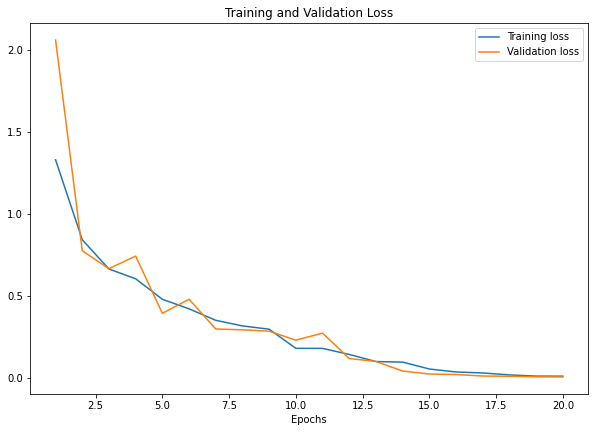

<Figure size 432x288 with 0 Axes>

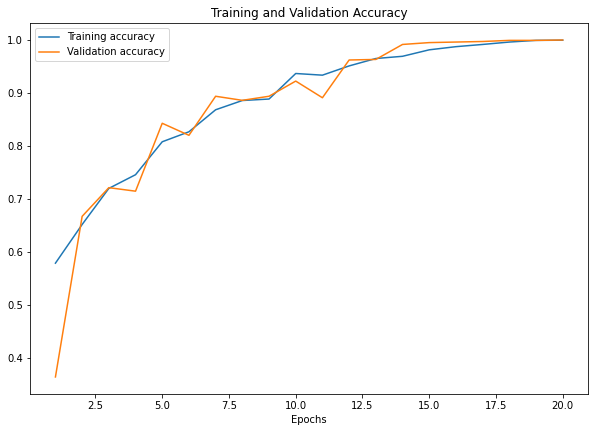

<Figure size 432x288 with 0 Axes>

In [35]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, train_losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, train_accs, label='Training accuracy')
plt.plot(epoch, val_accs, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

In [37]:
# summary results
for i, acc in enumerate(val_accs):
    print(f'Epoch {i + 1} - validation accuracy: {acc}')

Epoch 1 - validation accuracy: 0.3651567944250871
Epoch 2 - validation accuracy: 0.667595818815331
Epoch 3 - validation accuracy: 0.721602787456446
Epoch 4 - validation accuracy: 0.7149825783972126
Epoch 5 - validation accuracy: 0.8428571428571429
Epoch 6 - validation accuracy: 0.8202090592334494
Epoch 7 - validation accuracy: 0.8937282229965157
Epoch 8 - validation accuracy: 0.8860627177700349
Epoch 9 - validation accuracy: 0.8937282229965157
Epoch 10 - validation accuracy: 0.9222996515679442
Epoch 11 - validation accuracy: 0.8909407665505227
Epoch 12 - validation accuracy: 0.962020905923345
Epoch 13 - validation accuracy: 0.9630662020905923
Epoch 14 - validation accuracy: 0.9912891986062717
Epoch 15 - validation accuracy: 0.9947735191637631
Epoch 16 - validation accuracy: 0.9958188153310105
Epoch 17 - validation accuracy: 0.9968641114982578
Epoch 18 - validation accuracy: 0.9989547038327526
Epoch 19 - validation accuracy: 0.9989547038327526
Epoch 20 - validation accuracy: 0.999651567